In [9]:
# USER CONTROLS
N_WORLDS = 300
WORLD_LIBRARY_NAME = f"hostile_lib_{N_WORLDS}.pkl"


In [10]:
import sys, os
sys.path.append(os.path.abspath(".."))


In [11]:
import numpy as np
import matplotlib.pyplot as plt

from surfaces.base_surface import TemplateSurface
from surfaces.procedural_surface import procedural_surface
from mc.universe_sampler import precompute_hostile_worlds
from mc.world_cache import save_worlds, load_worlds
from mc.stress_tests import hostile_failure_test_cached


In [12]:
K = np.linspace(0.6, 1.4, 80)
T = np.linspace(0.02, 2.5, 80)
KK, TT = np.meshgrid(K, T)

IV_macro = 0.17 + 0.09*np.sqrt(TT) - 0.30*(KK-1) + 0.40*(KK-1)**2
template = TemplateSurface(KK, TT, IV_macro)


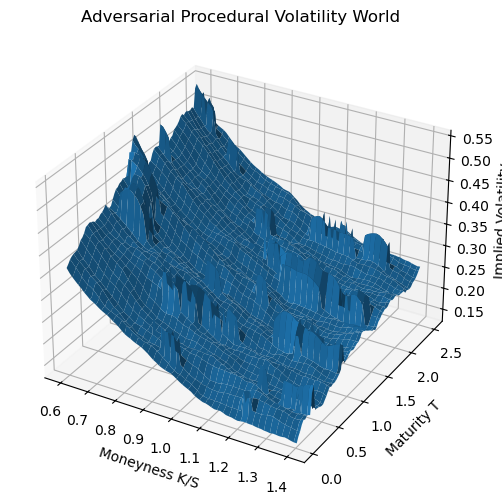

In [13]:
IV_world = procedural_surface(KK, TT, template, seed=13)

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(KK, TT, IV_world)
ax.set_xlabel("Moneyness K/S")
ax.set_ylabel("Maturity T")
ax.set_zlabel("Implied Volatility")
ax.set_title("Adversarial Procedural Volatility World")
plt.show()


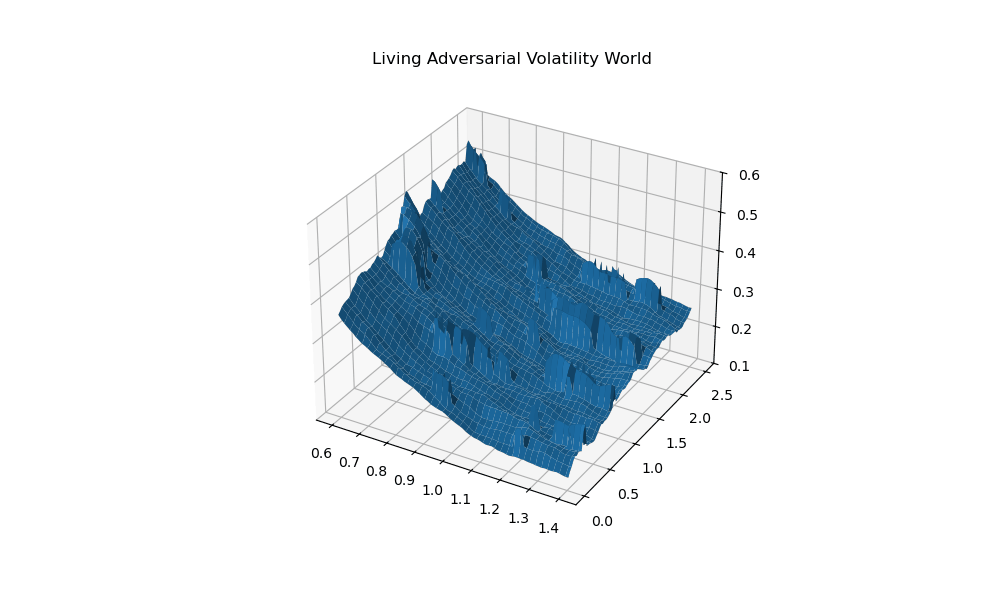

In [14]:
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import Image

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')

def animate(i):
    ax.clear()
    IV = procedural_surface(KK, TT, template, seed=13 + i)
    ax.plot_surface(KK, TT, IV)
    ax.set_zlim(0.1, 0.6)
    ax.set_title("Living Adversarial Volatility World")

ani = animation.FuncAnimation(fig, animate, frames=60, interval=120)
ani.save("living_world.gif", writer="pillow")
plt.close(fig)

Image(filename="living_world.gif")


In [15]:
worlds = precompute_hostile_worlds(template, KK, TT, n_worlds=N_WORLDS)
save_worlds(worlds, WORLD_LIBRARY_NAME)


'worldlibs\\hostile_lib_300.pkl'

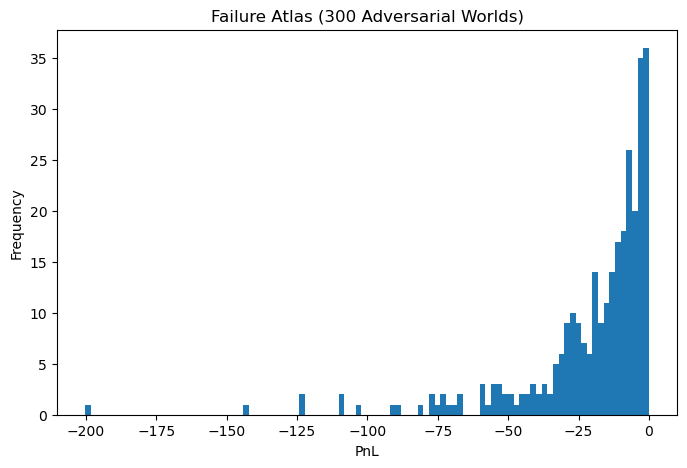

Mean: -20.384272
5% VaR: -70.93896
1% Tail: -122.53477


In [16]:
worlds = load_worlds(WORLD_LIBRARY_NAME)
pnls = hostile_failure_test_cached(worlds)

plt.figure(figsize=(8,5))
plt.hist(pnls, bins=100)
plt.xlabel("PnL")
plt.ylabel("Frequency")
plt.title(f"Failure Atlas ({N_WORLDS} Adversarial Worlds)")
plt.show()

print("Mean:", pnls.mean())
print("5% VaR:", np.percentile(pnls, 5))
print("1% Tail:", np.percentile(pnls, 1))


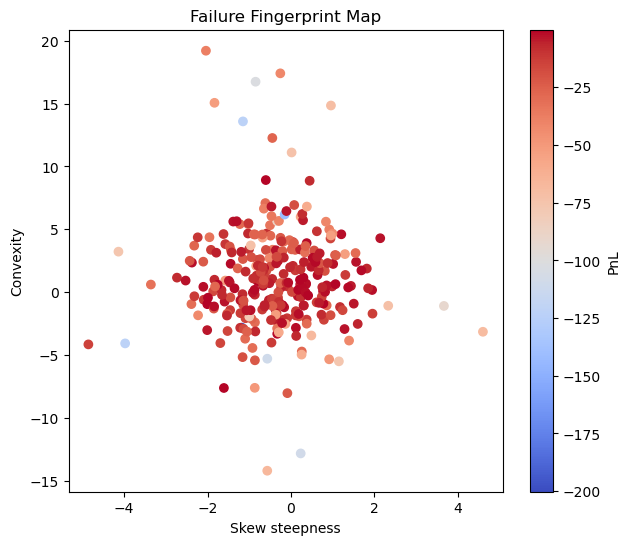

In [17]:
from mc.fingerprints import extract_fingerprints

feats, labels = extract_fingerprints(worlds, pnls)

plt.figure(figsize=(7,6))
plt.scatter(feats[:,0], feats[:,1], c=labels, cmap="coolwarm")
plt.xlabel("Skew steepness")
plt.ylabel("Convexity")
plt.title("Failure Fingerprint Map")
plt.colorbar(label="PnL")
plt.show()
